In [1]:
import os
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.table import Table, join
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
import astropy.units as u

import scipy.integrate as integrate
from scipy.optimize import fsolve

%matplotlib inline

In [2]:
# Import MAF
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
# import rubin_sim.data as data

In [3]:
opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/Users/jcarlin/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db
baseline_v2.1_10yrs


In [4]:
# Create a slicer based on known galaxies within 9 Mpc, with stellar mass > 10^7 M_Sun:
lv_slicer = maf.generateKnownLVDwarfSlicer()

In [5]:
# Set up the metric
mymetric = maf.LVDwarfsMetric() # for the discrete LV galaxies

In [6]:
# Define an sqlconstraint, if we need to just use a (large) subset of the opsim visits
sqlconstraint = '(filter = "g" OR filter = "i")'
# sqlconstraint = None   # no constraint, make all visits available

In [7]:
# Define the maps needed -- the stellar density in i band is required, dust map is not (default will be fine)
starmap = maf.StellarDensityMap(filtername='i')

In [8]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(mymetric, lv_slicer, sqlconstraint, mapsList=[starmap], runName=runName,
                         plotDict={'nTicks': 7})

In [9]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'LVDwarfs_metric': bundle}, opsim_fname, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

{'SkyMap': 1, 'Histogram': 2}

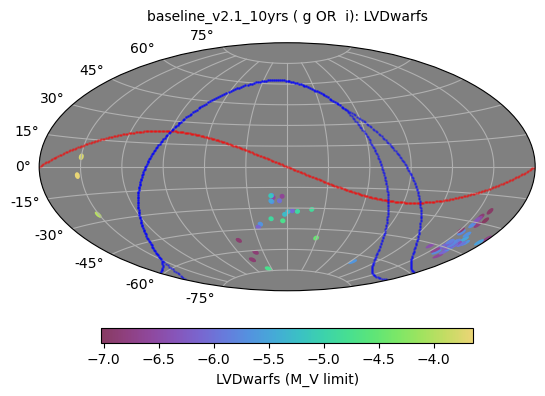

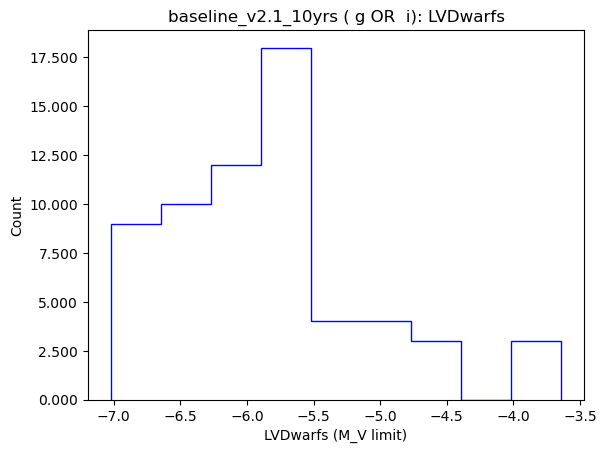

In [10]:
bundle.setPlotDict({'nTicks': 7})
bundle.plot()

In [11]:
cutoff = -6.4
summary_metric = maf.metrics.CountBeyondThreshold(lower_threshold=cutoff, metricName='Total detected')
bundle.setSummaryMetrics([summary_metric])
bundle.computeSummaryStats()
print(f"Number (out of {len(lv_slicer)}) of galaxies surveyed to the requested depth {cutoff}: "\
      f"{bundle.summaryValues['Total detected']}")

#cutoff = -7.0
#summary_metric = maf.metrics.CountBeyondThreshold(lower_threshold=cutoff, metricName='Total detected')
#bundle.setSummaryMetrics([summary_metric])
#bundle.computeSummaryStats()
#print(f"Number (out of {len(lv_slicer)}) of galaxies surveyed to the requested depth {cutoff}: "\
#      f"{bundle.summaryValues['Total detected']}")

Number (out of 302) of galaxies surveyed to the requested depth -6.4: 48


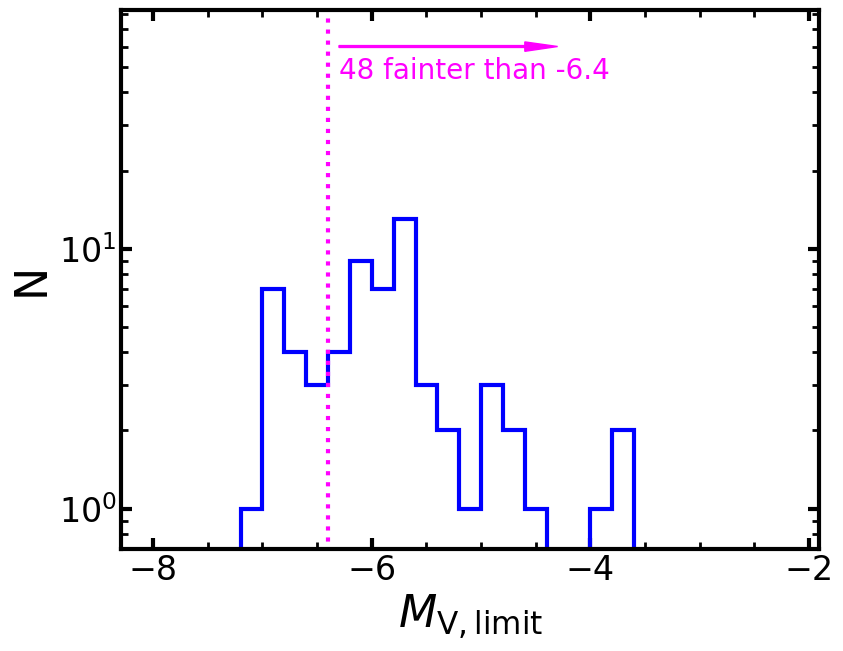

In [12]:
params = {
   'axes.labelsize': 32,
   'font.size': 24,
   'legend.fontsize': 20,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 8,
   'xtick.minor.size': 5,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 8,
   'ytick.minor.size': 5,
   'ytick.direction': 'in',
   'ytick.right': True,
   'figure.figsize': [9, 7],
   'figure.facecolor': 'White'
    }

plt.rcParams.update(params)

plt.hist(bundle.metricValues.compressed(), bins=np.arange(-8, -2, 0.2), log=True, histtype='step',
         color='Blue', label='All', linewidth=3)
plt.vlines(cutoff, 0, 200, color='magenta', linestyle=':', linewidth=3)
plt.arrow(cutoff+0.1, 60.0, 2, 0, color='magenta', width=1, length_includes_head=True, head_width=5, head_length=0.3)
plt.text(cutoff+0.1, 45, str(bundle.summaryValues['Total detected']) +' fainter than ' + str(cutoff), 
         color='magenta', fontsize='small')
plt.ylim(0.7, 83)

plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

In [13]:
# Extract the RA, Dec for the input LV hosts catalogs
# sc = SkyCoord(ra=bundle.slicer.getSlicePoints()['ra']*u.rad, dec=bundle.slicer.getSlicePoints()['dec']*u.rad)

In [14]:
# Read the original catalog in:
cat0 = fits.getdata('../lsst_galaxies_1p25to9Mpc_table.fits')

# Apply the same cuts used in the LVslicer:
keepcat = (cat0["dec"] < 35.0) & (cat0["MStars"] > 1e7) & (cat0["MStars"] < 1e14)

cat = Table(cat0[keepcat])

In [15]:
# Update the table with extinction and M_V limits columns:
cat.add_columns([bundle.slicer.getSlicePoints()['ebv'], bundle.metricValues.data], names=['ebv', 'mv_limit'])

In [16]:
# Select hosts with stellar masses >= 1/3 * M_*,SMC:
mstar_smc = 7.1e8
mstar_lmc = 2.6e9
mstar_mw = 7e10

stellar_mass_cut = mstar_smc/3.0

cat_lower_mass_cut = cat[cat['Mstars'] > stellar_mass_cut]
cat_mass_and_dist_cut = cat_lower_mass_cut[cat_lower_mass_cut['dist_Mpc'] < 6.0]

In [17]:
# Change the right side here to select a different version of the catalog (i.e., different cuts):
cat_all = cat_mass_and_dist_cut
sc = SkyCoord(ra=cat_all['ra']*u.deg, dec=cat_all['dec']*u.deg)

cat_all.sort('Mstars')

In [18]:
distances = cat_all['dist_Mpc']
mv_limits = cat_all['mv_limit']

# Hosts where no satellites will be detectable as resolved stars have the M_V limit set to -666.0.
#   Flag those with no limit:
nolimit = (mv_limits < -30) | (np.abs(mv_limits) < 0.1)

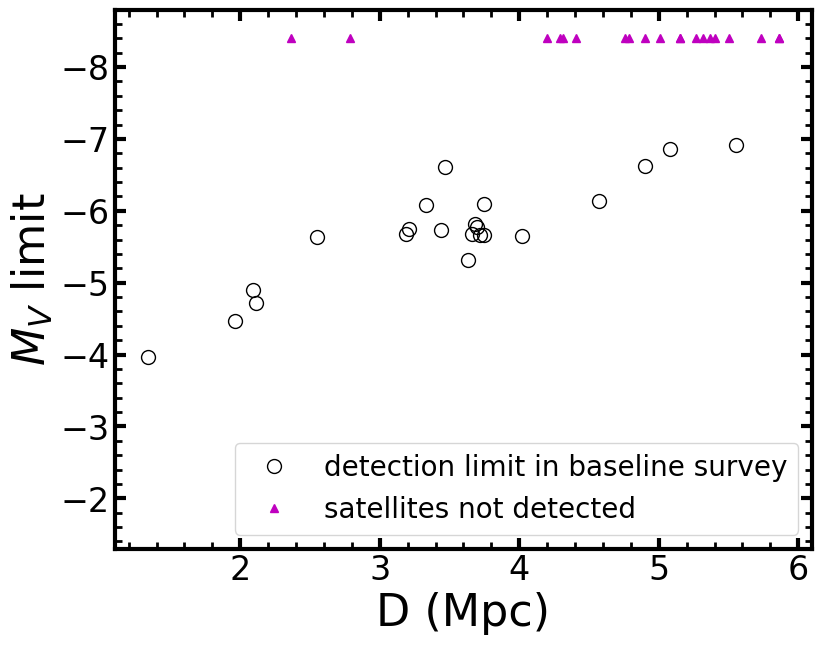

In [19]:
plt.plot(distances[~nolimit], mv_limits[~nolimit], 'k.', ms=20, fillstyle='none', label='detection limit in baseline survey')
tmparr = np.repeat(-8.4, len(mv_limits))
plt.plot(distances[nolimit], tmparr[nolimit], 'm^', label='satellites not detected')
plt.ylim(-1.3, -8.8)
plt.xlim(1.1, 6.1)
plt.minorticks_on()
plt.legend(loc='lower right')
plt.xlabel('D (Mpc)')
plt.ylabel('$M_V$ limit')
plt.show()

Which ones have no detected satellites?

In [20]:
#print(cat_all[nolimit]['ebv'])
#
#print(sc[nolimit].galactic)
print(cat_all[nolimit])

   name            ra                 dec          M_B  SBB   AB        Mstars       dist_Mpc         ebv            mv_limit 
---------- ------------------ ------------------- ----- ---- ---- ------------------ -------- -------------------- -----------
    IC3104 184.69208333333333  -79.72611111111111 -14.9 24.2  1.7 257039578.27688646     2.36  0.41601935029029846      -666.0
 NGC4656UV 191.06541666666664   32.28333333333333 -15.7 25.4 0.06   346736850.452531      5.4 0.013604354113340378    9.5e-322
   NGC5408 210.83958333333334  -41.37638888888889 -16.7 22.9  0.3  371535229.0971728     5.32  0.06761705875396729      -666.0
  UGC01281 27.384583333333328             32.5925 -16.2 24.7  0.2  371535229.0971728     5.27 0.046010736376047134         0.0
   NGC1705  73.55708333333332  -53.36138888888889 -16.1 23.0 0.03 416869383.47033465     5.73 0.008298336528241634      -666.0
      KK49  85.42291666666665   6.681666666666667 -14.9 23.7 2.46  457088189.6148752     5.15   0.5804887413978

Of these 15, 6 have high(-ish) extinction (A_B > 1 mag). Four of them are near the distance limit (D >= 5.5 Mpc). The rest appear to be outside of the footprint in the baseline cadence.

What do the stellar masses of the hosts included/not-included look like?

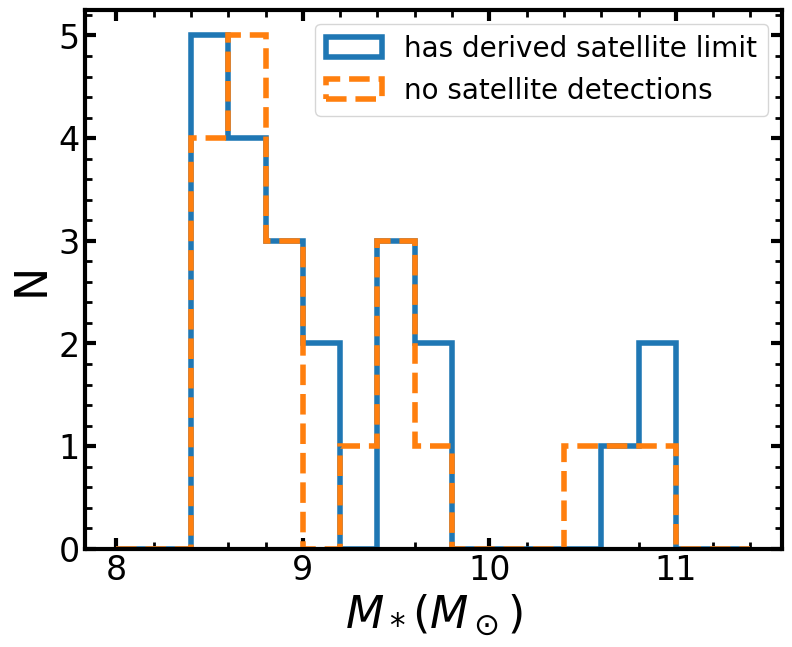

In [21]:
plt.hist(np.log10(cat_all[~nolimit]['Mstars']), bins=np.arange(8, 11.5, 0.2), histtype='step',
         linewidth=4, label='has derived satellite limit')
plt.hist(np.log10(cat_all[nolimit]['Mstars']), bins=np.arange(8, 11.5, 0.2), histtype='step',
         linewidth=4, linestyle='--', label='no satellite detections')
plt.legend()
plt.minorticks_on()
plt.xlabel('$M_* (M_\odot)$')
plt.ylabel('N')
plt.show()

Looks like the baseline cadence misses a couple of massive (>10^10.5 M_Sun) hosts, and 4 ~LMC-mass hosts.

## Simulate satellite luminosity functions to see the effect of survey design on measured LF

Now generate simulated satellite luminosity functions for all the hosts, and see what the total detected LF would look like.

We'll use the host-mass-dependent satellite luminosity function from [Nickerson+2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.429..452N/abstract)

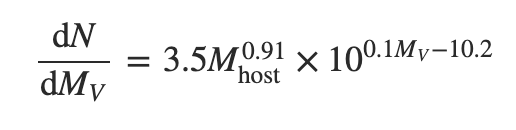


In [22]:
def dndm_nickerson(mhost, mvmin=-17, mvmax=-5, mvstep=0.5):
    mv = np.arange(mvmin, mvmax, mvstep)
    dndm = (3.5*(mhost**0.91))*(10.0**(0.1*mv-10.2))
    return mv, dndm

def dndm(mv, mhost):
    dndm = (3.5*(mhost**0.91))*(10.0**(0.1*mv-10.2))
    return dndm


Next, create a function to integrate the luminosity function and return a cumulative luminosity function.

In [23]:
def get_lf(mhost, mvmin=-20, mvmax=0, mvstep=0.2, slope=3.5, powerlaw_coeff=0.91, mv_turnover=10.2):
    mv = np.arange(mvmin, mvmax, mvstep)
    n_gt_mv = []

    for m in mv:
        nsats = integrate.quad(dndm, mvmin, m, args=(mhost))
        n_gt_mv.append(nsats[0])
    
    return mv, np.array(n_gt_mv)

Confirm that this produces reasonable results:

In [24]:
mhost = 1e12
mm0, lf0 = get_lf(mhost)
mm_half, lf_half = get_lf(mhost/2)
mm2, lf2 = get_lf(mhost*2)

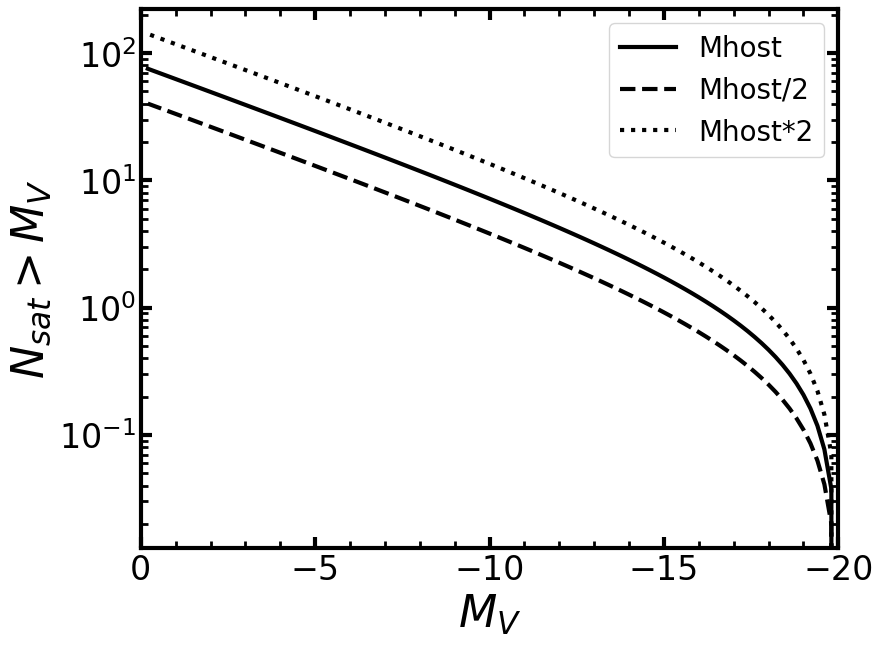

In [25]:
plt.plot(mm0, lf0, color='Black', linestyle='-', label='Mhost')
plt.plot(mm_half, lf_half, color='Black', linestyle='--', label='Mhost/2')
plt.plot(mm2, lf2, color='Black', linestyle=':', label='Mhost*2')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.xlim(0, -20)
plt.xlabel('$M_V$')
plt.ylabel('$N_{sat} > M_V$')
plt.show()

To derive halo masses for host galaxies based on their luminosities (stellar masses), adopt the stellar mass-halo mass (SMHM) relation from [Moster+2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.428.3121M/abstract)

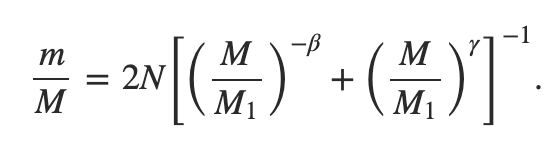

M: DM halo mass

m: galaxy stellar mass

beta: low-mass slope

-gamma: high-mass slope

N: normalization at M_1

Fit coefficients from Moster+2013:

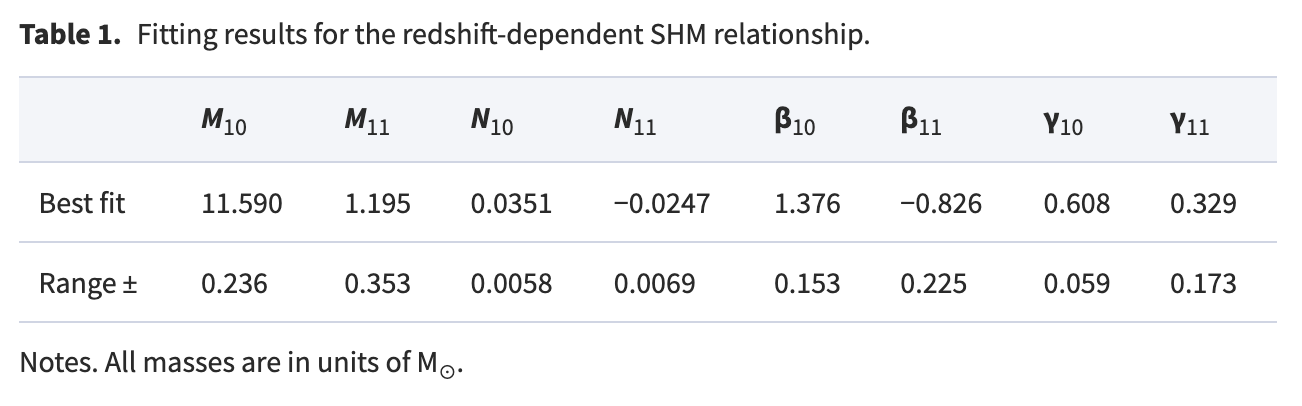

At z=0, M1=M10, etc., and _11 terms are unnecessary.

In [26]:
def smhm_moster(mhalo, mstar):
    m_1 = 10.0**11.590 # log(M_1) = M_10, so M_1 = 10^M_10
    n = 0.0351
    beta = 1.376
    gamma = 0.608
    fact1 = ((mhalo/m_1)**(-1.0*beta)) + ((mhalo/m_1)**gamma)
    fact2 = 2*n*(1/fact1)
    return mhalo*fact2 - mstar

def mhalo_from_mstar(mstar):
    # Function to numerically solve for the halo mass given stellar mass.
    #   Use 10*M_star as starting guess for M_host
    return fsolve(smhm_moster, mstar*10, args=(mstar))

Confirm that this produces reasonable results:

In [27]:
#log_mstar = np.arange(8, 13, 0.1)
ms = np.geomspace(1e7, 1e12, 50)
mh = []

for mass in ms:
    mh_tmp = mhalo_from_mstar(mass)
    mh.append(mh_tmp[0])

[]

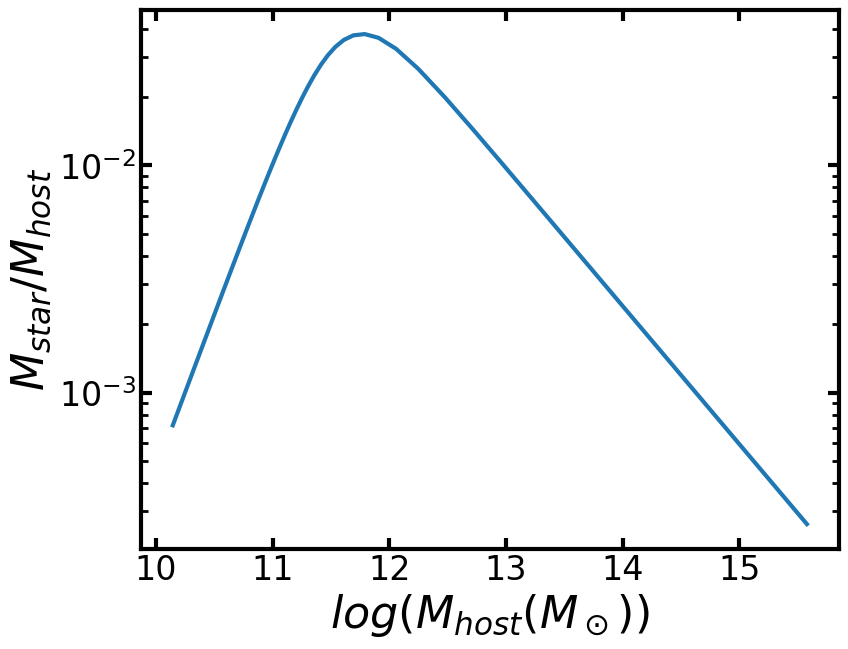

In [28]:
plt.plot(np.log10(mh), ms/mh)
plt.semilogy()
plt.xlabel('$log(M_{host} (M_\odot))$')
plt.ylabel('$M_{star}/M_{host}$')
plt.plot()

In [29]:
# Loop over the hosts and generate a simulated LF for each:
#
# Note: "withlimit" is the simulated LF with the detection limit from sims_maf applied

mvbins_all = []
lf_all = []
mhost_all = []
lf_withlimit_all = []

mvmin = -20
mvmax = -3
mvstep = 0.2

# for gx in cat_lower_mass_cut:
for gx in cat_all:
    #print(gx['Mstars'])
    mh = mhalo_from_mstar(gx['Mstars'])
    mhost_all.append(mh)
    mm, lf = get_lf(mh, mvmin=mvmin, mvmax=mvmax, mvstep=mvstep)
    mvbins_all.append(mm)
    lf_all.append(lf)
    lf_withlimit = lf.copy()
    if (gx['mv_limit'] < -0.5) & (gx['mv_limit'] > -20):
        ok_mv_ind = np.argmin(np.abs(mm-gx['mv_limit']))
        lf_withlimit[ok_mv_ind:] = lf[ok_mv_ind]
    else:
        lf_withlimit *= 0
    lf_withlimit_all.append(lf_withlimit)


In [30]:
# Create summed luminosity functions (i.e., the sum of satellites from all observed hosts)

lfsum = np.zeros(len(lf_all[0]))
lfsum_withlimit = np.zeros(len(lf_withlimit_all[0]))

for lfbin in lf_all:
    lfsum += lfbin

for lfbin in lf_withlimit_all:
    lfsum_withlimit += lfbin

In [31]:
#lf_withlimit_all

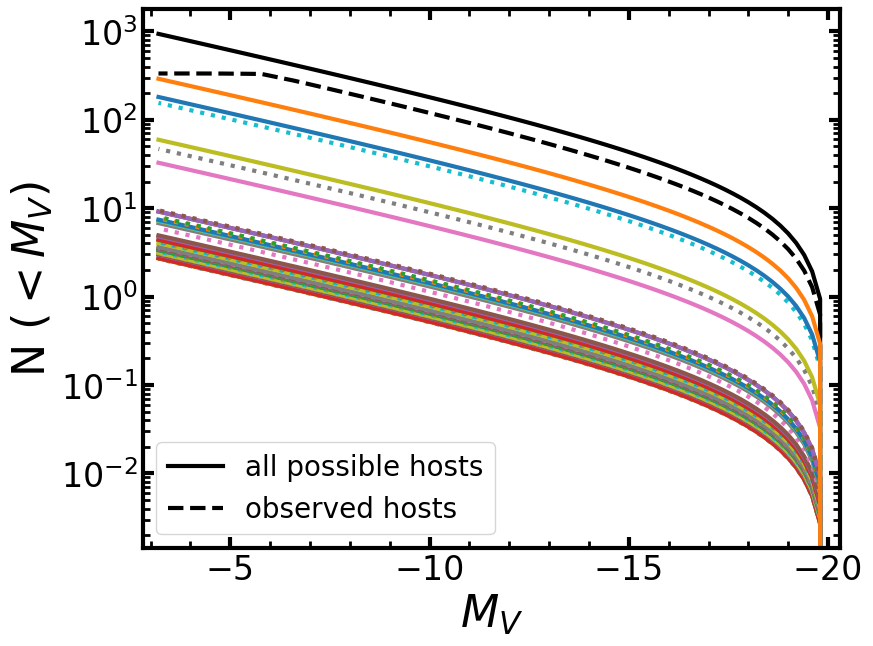

In [32]:
# Black: summed LFs from all hosts. 
#        Solid line is all possible satellites.
#        Dashed line includes effects of observing strategy.
# Colors: individual LFs for all hosts. 
#         Solid: has a detection limit from the baseline cadence.
#         Dotted: no satellites observed in baseline cadence.

fig = plt.figure(figsize=(9, 7))

plt.plot(mvbins_all[0], lfsum, color='Black', label='all possible hosts')
plt.plot(mvbins_all[0], lfsum_withlimit, color='Black', linestyle='--', label='observed hosts')

for i in range(len(mvbins_all)):
    if cat_mass_and_dist_cut[i]['mv_limit'] < -30:
    # if cat_lower_mass_cut[i]['mv_limit'] < -30:
        line = ':'
    else:
        line = '-'
    plt.plot(mvbins_all[i], lf_all[i], linestyle=line, label='__none__')

plt.semilogy()
plt.legend(loc='lower left')
plt.minorticks_on()
plt.xlim(-2.8, -20.3)
plt.xlabel('$M_V$')
plt.ylabel('N $(< M_V)$')
plt.show()

## Effects of changing satellite populations:

In [33]:
# Hosts with log(Mstar)>9.3 have twice as many satellites:

lowmass_host_sel = np.where(np.log10(cat_all['Mstars']) < 9.3)
suppress_sats_lowmass_lf = lf_all.copy()

for sel in lowmass_host_sel[0]:
    suppress_sats_lowmass_lf[sel] = suppress_sats_lowmass_lf[sel]/2

lfsum_suppress_sats_lowmass = np.zeros(len(suppress_sats_lowmass_lf[0]))

for lfbin in suppress_sats_lowmass_lf:
    lfsum_suppress_sats_lowmass += lfbin

#######################
# Hosts with log(Mstar)>9.3 have half as many satellites:
increase_sats_lowmass_lf = lf_all.copy()

for sel in lowmass_host_sel[0]:
    increase_sats_lowmass_lf[sel] = increase_sats_lowmass_lf[sel]*2

lfsum_increase_sats_lowmass = np.zeros(len(increase_sats_lowmass_lf[0]))

for lfbin in increase_sats_lowmass_lf:
    lfsum_increase_sats_lowmass += lfbin

#######################
# Hosts with log(Mstar)>10.3 have twice as many satellites:

highmass_host_sel = np.where(np.log10(cat_all['Mstars']) > 10.3)
suppress_sats_highmass_lf = lf_all.copy()

for sel in highmass_host_sel[0]:
    suppress_sats_highmass_lf[sel] = suppress_sats_highmass_lf[sel]/2

lfsum_suppress_sats_highmass = np.zeros(len(suppress_sats_highmass_lf[0]))

for lfbin in suppress_sats_highmass_lf:
    lfsum_suppress_sats_highmass += lfbin

#######################
# Hosts with log(Mstar)>9.3 have half as many satellites:

increase_sats_highmass_lf = lf_all.copy()

for sel in highmass_host_sel[0]:
    increase_sats_highmass_lf[sel] = increase_sats_highmass_lf[sel]*2

lfsum_increase_sats_highmass = np.zeros(len(increase_sats_highmass_lf[0]))

for lfbin in increase_sats_highmass_lf:
    lfsum_increase_sats_highmass += lfbin

In [34]:
highmass_host_sel

(array([36, 37, 38, 39, 40, 41]),)

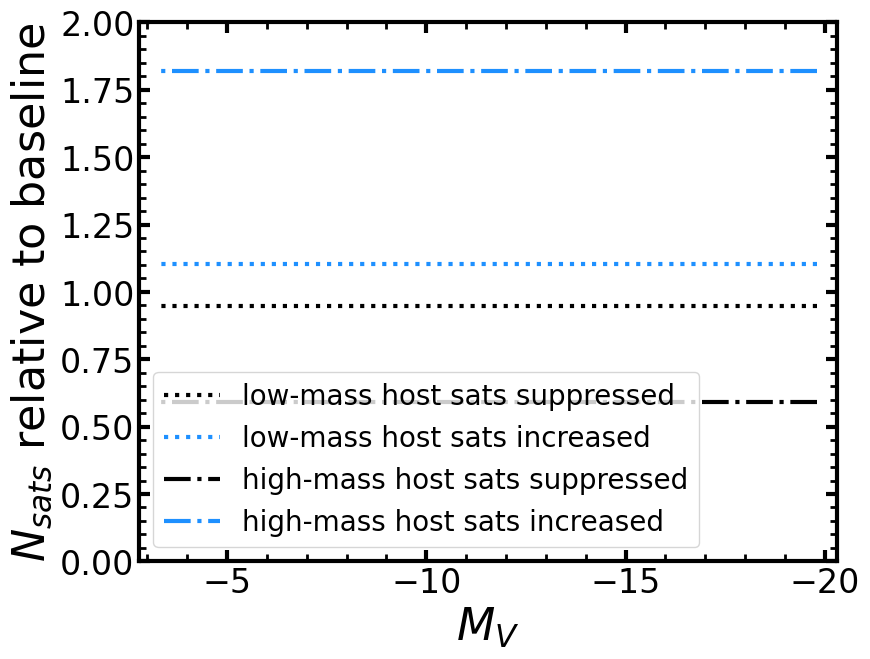

In [35]:
# Black: summed LFs from all hosts. 
#        Solid line is all possible satellites.
#        Dashed line includes effects of observing strategy.
# Colors: individual LFs for all hosts. 
#         Solid: has a detection limit from the baseline cadence.
#         Dotted: no satellites observed in baseline cadence.

fig = plt.figure(figsize=(9, 7))

# plt.plot(mvbins_all[0], lfsum, color='Black', label='all possible hosts')
#plt.plot(mvbins_all[0], lfsum_withlimit, color='Black', linestyle='--', label='observed hosts')
plt.plot(mvbins_all[0], lfsum_suppress_sats_lowmass/lfsum, color='Black', linestyle=':', label='low-mass host sats suppressed')
plt.plot(mvbins_all[0], lfsum_increase_sats_lowmass/lfsum, color='DodgerBlue', linestyle=':', label='low-mass host sats increased')
plt.plot(mvbins_all[0], lfsum_suppress_sats_highmass/lfsum, color='Black', linestyle='-.', label='high-mass host sats suppressed')
plt.plot(mvbins_all[0], lfsum_increase_sats_highmass/lfsum, color='DodgerBlue', linestyle='-.', label='high-mass host sats increased')

#for i in range(len(mvbins_all)):
#    if cat_mass_and_dist_cut[i]['mv_limit'] < -30:
#    # if cat_lower_mass_cut[i]['mv_limit'] < -30:
#        line = ':'
#    else:
#        line = '-'
#    plt.plot(mvbins_all[i], lf_all[i], linestyle=line, label='__none__')

# plt.semilogy()
plt.legend(loc='lower left')
plt.minorticks_on()
plt.xlim(-2.8, -20.3)
plt.ylim(0, 2)
plt.xlabel('$M_V$')
plt.ylabel('$N_{sats}$ relative to baseline')
plt.show()

In [36]:
mvlim = -6.4

numsats_model = []
numsats_model_obs = []

for i in range(len(lf_all)):
    okind = np.argmin(np.abs(mvbins_all[i]-mvlim))
    numsats_model.append(lf_all[i][okind])
    if nolimit[i] == False:
        numsats_model_obs.append(lf_all[i][okind])

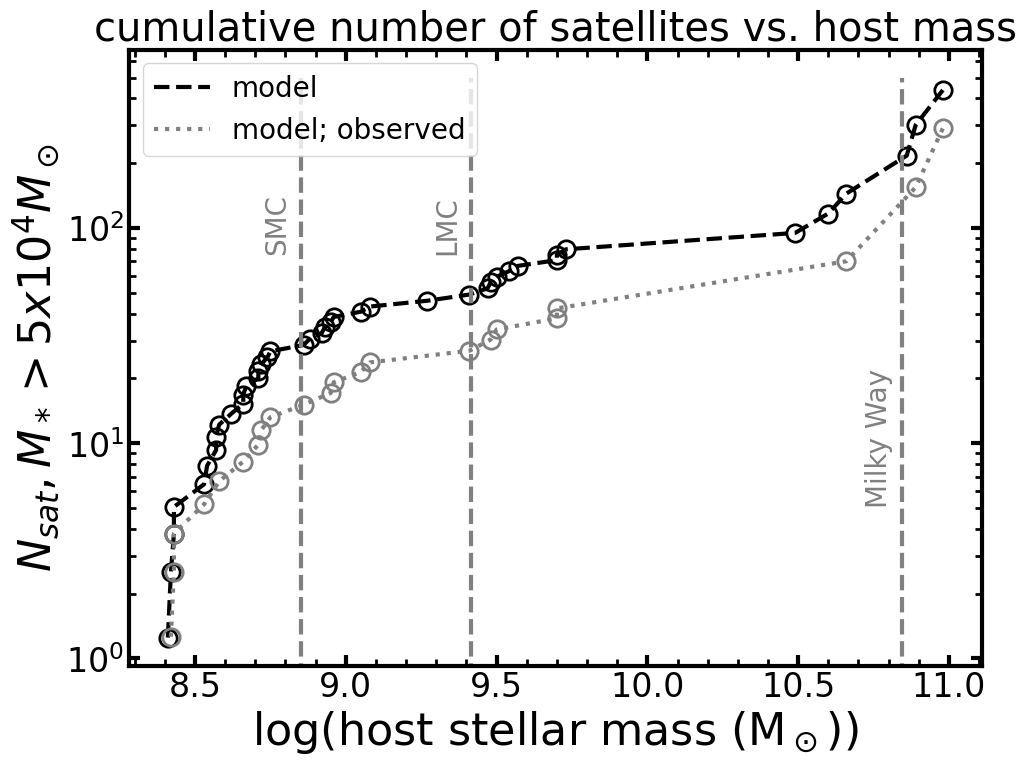

In [37]:
fig = plt.figure(figsize=(11, 8))
plt.plot(np.log10(cat_all['Mstars']), np.cumsum(numsats_model), color='Black', linestyle='--', label='model')
plt.plot(np.log10(cat_all['Mstars']), np.cumsum(numsats_model), '.', ms=25, color='Black',
         label='__model', fillstyle='none', markeredgewidth=2)
plt.plot(np.log10(cat_all[~nolimit]['Mstars']), np.cumsum(numsats_model_obs), color='Gray', linestyle=':', label='model; observed')
plt.plot(np.log10(cat_all[~nolimit]['Mstars']), np.cumsum(numsats_model_obs), '.', ms=25, color='Gray',
         label='__model', fillstyle='none', markeredgewidth=2)
#plt.plot(np.log10(cat_all['Mstars']), np.cumsum(cat_all['nsat']), label='$M_* > M_{*,SMC}/3; 1.3 < D < 6$~Mpc')
#plt.plot(np.log10(cat_all['Mstars']), np.cumsum(cat_all['nsat']), 'k.', ms=15, label='__none__')
##plt.plot(np.log10(cat_all['Mstars']), np.cumsum(cat_all['nsat'])/np.sum(cat_all['nsat']))

plt.vlines(np.log10(mstar_smc), 0, 500, linestyle='--', color='gray')
plt.vlines(np.log10(mstar_lmc), 0, 500, linestyle='--', color='gray')
plt.vlines(np.log10(mstar_mw), 0, 500, linestyle='--', color='gray')
plt.text(np.log10(mstar_smc*0.75), 75, 'SMC', color='gray',
         size=20, horizontalalignment='left', verticalalignment='bottom', rotation=90)
plt.text(np.log10(mstar_lmc*0.75), 75, 'LMC', color='gray',
         size=20, horizontalalignment='left', verticalalignment='bottom', rotation=90)
plt.text(np.log10(mstar_mw*0.75), 5, 'Milky Way', color='gray',
         size=20, horizontalalignment='left', verticalalignment='bottom', rotation=90)

#for i in range(len(cat_all)):
#    if np.mod(i, 5) == 0 and i>0:
#        plt.plot(np.log10(cat_all[i]['Mstars']), cumulative_nsat[i], 'r.', ms=15, label='__none__')

plt.xlabel('log(host stellar mass (M$_\odot$))')
plt.ylabel('$N_{sat}, M_* > 5x10^4 M_\odot$')
plt.title('cumulative number of satellites vs. host mass')
plt.legend()
# plt.ylim(-3, 338) # for D<9 Mpc
# plt.ylim(-3, 148) # for D<6 Mpc
plt.minorticks_on()
plt.semilogy()
# plt.savefig('nsats_vs_host_mass_D_lt_6Mpc.png', dpi=300)
plt.show()

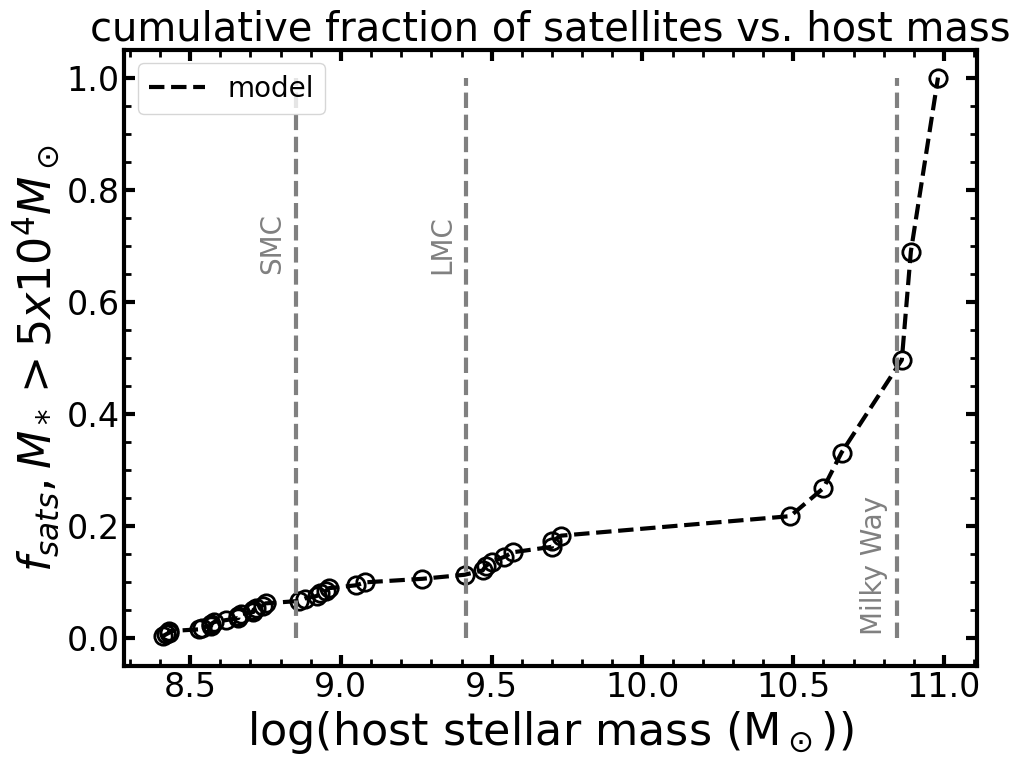

In [38]:
fig = plt.figure(figsize=(11, 8))
plt.plot(np.log10(cat_all['Mstars']), np.cumsum(numsats_model)/np.sum(numsats_model), color='Black',
         linestyle='--', label='model')
plt.plot(np.log10(cat_all['Mstars']), np.cumsum(numsats_model)/np.sum(numsats_model), '.', ms=25,
         color='Black', label='__model', fillstyle='none', markeredgewidth=2)
#plt.plot(np.log10(cat_all[~nolimit]['Mstars']), np.cumsum(numsats_model_obs)/np.sum(numsats_model), color='Gray', linestyle='--', label='model; observed')
#plt.plot(np.log10(cat_all[~nolimit]['Mstars']), np.cumsum(numsats_model_obs)/np.sum(numsats_model), '.', ms=25, color='Gray',
#         label='__model', fillstyle='none', markeredgewidth=2)

plt.vlines(np.log10(mstar_smc), 0, 1, linestyle='--', color='gray')
plt.vlines(np.log10(mstar_lmc), 0, 1, linestyle='--', color='gray')
plt.vlines(np.log10(mstar_mw), 0, 1, linestyle='--', color='gray')
plt.text(np.log10(mstar_smc*0.75), 0.65, 'SMC', color='gray',
         size=20, horizontalalignment='left', verticalalignment='bottom', rotation=90)
plt.text(np.log10(mstar_lmc*0.75), 0.65, 'LMC', color='gray',
         size=20, horizontalalignment='left', verticalalignment='bottom', rotation=90)
plt.text(np.log10(mstar_mw*0.75), 0.005, 'Milky Way', color='gray',
         size=20, horizontalalignment='left', verticalalignment='bottom', rotation=90)

plt.xlabel('log(host stellar mass (M$_\odot$))')
plt.ylabel('$f_{sats}, M_* > 5x10^4 M_\odot$')
plt.title('cumulative fraction of satellites vs. host mass')
plt.legend()
# plt.ylim(-3, 338) # for D<9 Mpc
# plt.ylim(-3, 148) # for D<6 Mpc
plt.minorticks_on()
#plt.semilogy()
# plt.savefig('nsats_vs_host_mass_D_lt_6Mpc.png', dpi=300)
plt.show()

## Metrics calculating satellite limiting mag at D=4 Mpc

In [39]:
nside = 32

mymetric2 = maf.LVDwarfsMetric(distlim=4.0*u.Mpc) # for a distance limit, healpix map
dustmap = maf.DustMap(nside=nside) # Not necessary, but removes warning message
healpix_slicer = maf.HealpixSlicer(nside=nside, useCache=False)
bundle2 = maf.MetricBundle(mymetric2, healpix_slicer, sqlconstraint, mapsList=[starmap, dustmap], runName=runName)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [40]:
g2 = maf.MetricBundleGroup({'LVDwarfs_area_metric': bundle2}, opsim_fname, outDir='test', resultsDb=None)
g2.runAll()

{'SkyMap': 1, 'Histogram': 2}

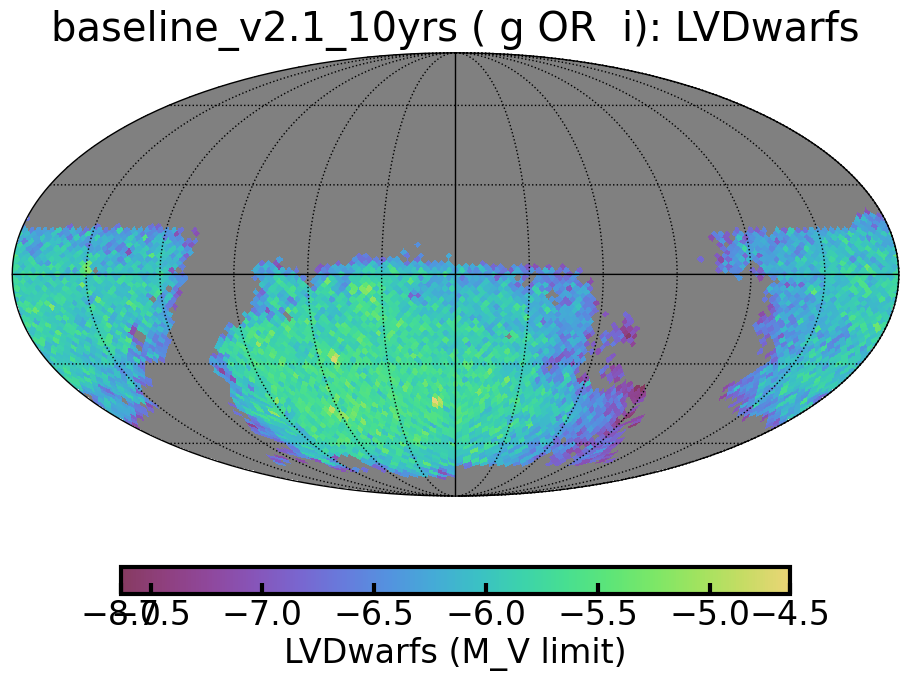

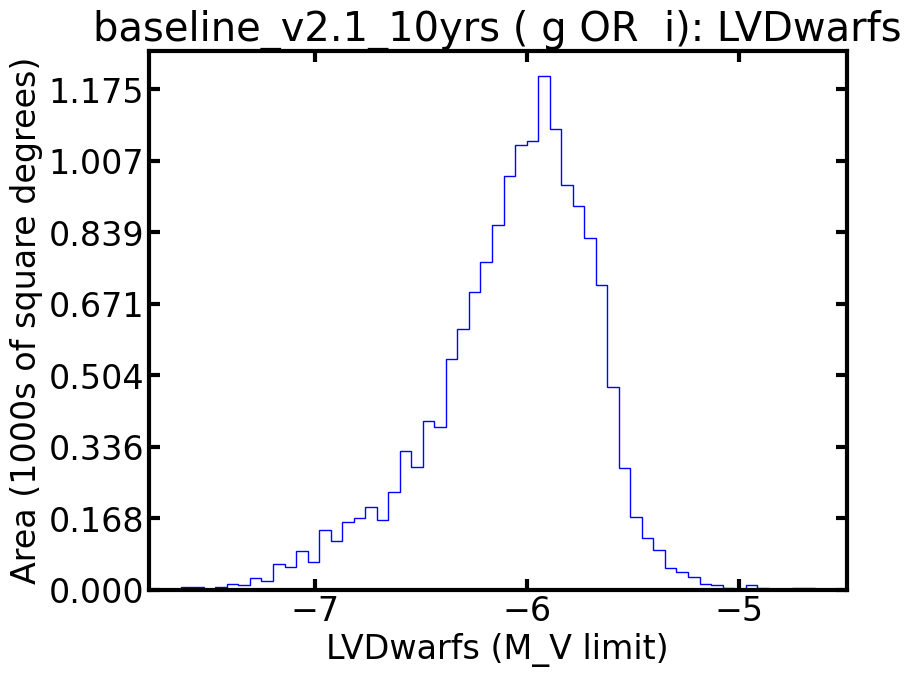

In [41]:
bundle2.setPlotDict({'nTicks': 7})
bundle2.plot()

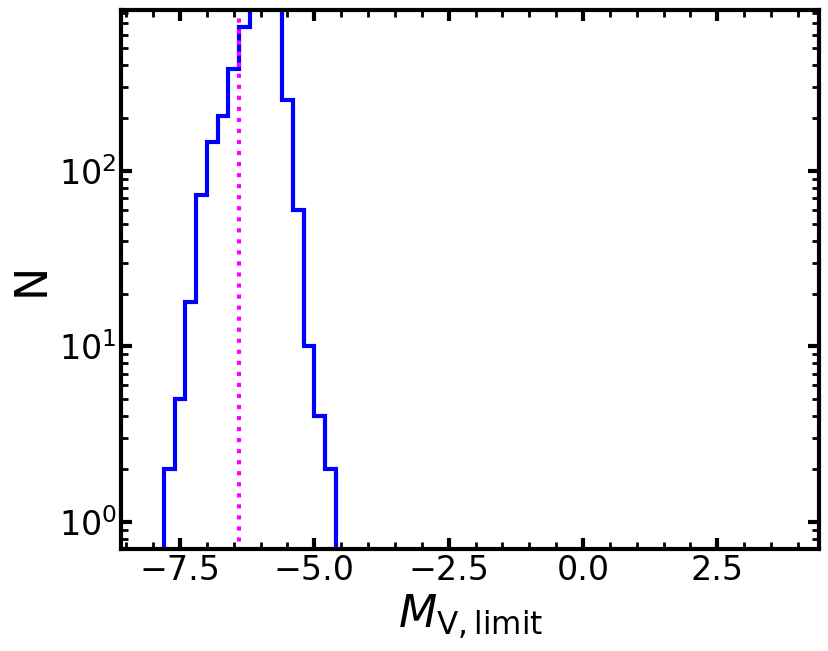

In [42]:
plt.hist(bundle2.metricValues.compressed(), bins=np.arange(-8, 4, 0.2), log=True, histtype='step',
         color='Blue', linewidth=3)
plt.vlines(cutoff, 0, 1000, color='magenta', linestyle=':', linewidth=3)
plt.ylim(0.7, 830)
#plt.xlim(-9.3, 1.8)
plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

In [43]:
summary_area = maf.AreaThresholdMetric(lower_threshold=cutoff)
bundle2.setSummaryMetrics([summary_area])
bundle2.computeSummaryStats()
bundle2.summaryValues

{'AreaThreshold': 13660.34336945695}